In [1]:
# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

## 7.1 투표 기반 분류기

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(
    coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

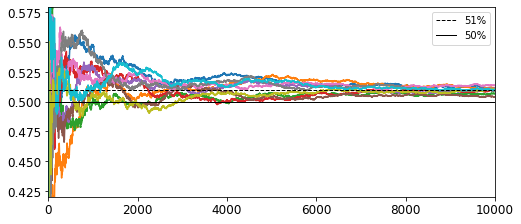

In [3]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], 'k--', linewidth=1, label='51%')
plt.plot([0, 10000], [0.5, 0.5], 'k-', linewidth=1, label='50%')
plt.axis([0, 10000, 0.42, 0.58])
plt.legend(loc='best')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict


In [5]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', probability=True, random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                         ('rf', rnd_clf),
                                         ('svc', svm_clf)],
                             voting='soft')
voting_clf.fit(X_train, y_train)

/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [6]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


/data/data/com.termux/files/usr/lib/python3.8/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 7.2 배깅과 페이스팅

배깅 bagging
- bootstrap aggregating의 줄임말
- 훈련 세트에서 중복을 허용하여 샘플링하는 방식

페이스팅 pasting
- 중복을 허용하지 안고 샘플링하는 방식

수집 ㅎㅏㅁ수는 
분류일 때는 
- 통게적 최빈값 statistical mode (직접 투표 분류기처럼 가장 많은 예측 결과)

회귀일 때
- 평균 을 계산

### 7.2.1 사이킷런의 배깅과 페이스팅

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42),
                           n_estimators=500,
                           max_samples=100,
                           bootstrap=True,
                           n_jobs=-1,
                           random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [8]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [9]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [12]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)

numpy.c_ = <numpy.lib.index_tricks.CClass object>
- Translates slice objects to concatenation along the second axis.

- This is short-hand for np.r_['-1,2,0', index expression], which is useful because of its common occurrence. In particular, arrays will be stacked along their last axis after being upgraded to at least 2-D with 1’s post-pended to the shape (column vectors made out of 1-D arrays).

numpy.meshgrid(\*xi, \*\*kwargs)[source](https://numpy.org/doc/1.17/reference/generated/numpy.meshgrid.html?highlight=meshgrid#numpy.meshgrid)
- Return coordinate matrices from coordinate vectors.

- Make N-D coordinate arrays for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays x1, x2,…, xn.

Returns:	
- X1, X2,…, XN : ndarray
  - For vectors x1, x2,…, ‘xn’ with lengths Ni=len(xi) , return (N1, N2, N3,...Nn) shaped arrays if indexing=’ij’ or (N2, N1, N3,...Nn) shaped arrays if indexing=’xy’ with the elements of xi repeated to fill the matrix along the first dimension for x1, the second for x2 and so on.

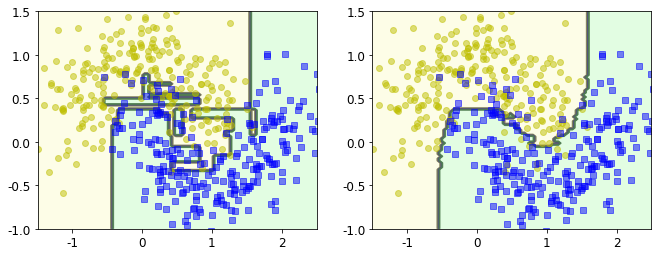

In [13]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)

plt.show()

결론

앙상블의 예측이 결정 트리 ㅎ나의 예측보다 일반화가 더 잘된 것 같이 보인다. 비슷한 편향에서 더 작은 분산을 만든다.

부트스트래핑은 서브셋에 다양성을 증가시키므로 대개 배깅이 페이스팅보다 편향이 조금 더 높다. 하지만 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다. 전반적으로 배깅이 더 나은 모델을 만들기 때문에 더 선호된다.

### 7.2.2 oob 평가

BaggingClassifier는 bootstrap=True, 훈련 세트 크기만큼인 m개의 샘플을 선택.

m이 커지면 $1-exp(-1) \approx 63.212%$에 가까워진다. 이는 선택되지 않은 37%가 있음을 의미한다. 

BaggingClassifier를 마ㄴ들 때 oob_score=True로 설정하면 훈련이 끝난 후 자동으로 oob평가를 수행한다.

In [23]:
bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=500,
                               bootstrap=True,
                               n_jobs=-1,
                               oob_score=True,
                               random_state=42)

bag_clf_oob.fit(X_train, y_train)
bag_clf_oob.oob_score_

0.8986666666666666

In [24]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf_oob.predict(X_test)

accuracy_score(y_test, y_pred)

0.912

In [25]:
bag_clf_oob.score(X_test, y_test)

0.912

## 7.3 랜덤 패치와 랜덤 서브스페이스

## 7.4 랜덤포레스트

### 7.4.1 엑스트라 트리

### 7.4.2 특성 중요도

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500,
                                 n_jobs=-1,
                                 random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


In [32]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
              interpolation="nearest")
    plt.axis("off")

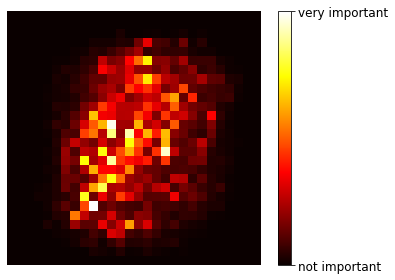

In [39]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), 
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['not important', 'very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## 7.5 부스팅 boosting

### 7.5.1 AdaBoost(Adaptive Boosting)

In [40]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators=200,
                            algorithm="SAMME.R",
                            learning_rate=0.5,
                            random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

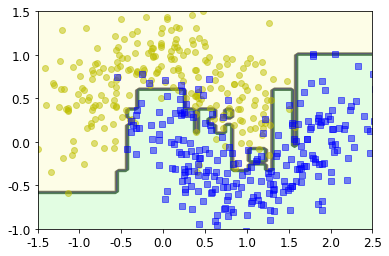

In [41]:
plot_decision_boundary(ada_clf, X, y)

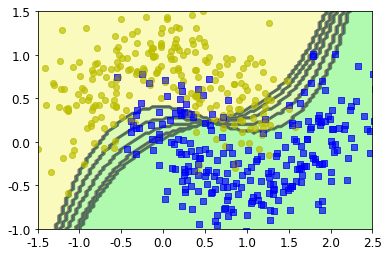

In [48]:
m = len(X_train)
sample_weights = np.ones(m)
learning_rate = 0.5

for i in range(5):
    svm_clf = SVC(kernel="rbf", C=0.05, gamma="auto", random_state=42)
    svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = svm_clf.predict(X_train)
    sample_weights[y_pred != y_train] *= (1 + learning_rate)
    plot_decision_boundary(svm_clf, X, y, alpha=0.2)

### 7.5.2 그래디언트 부스팅 Gradient Boosting

Residual Error잔차 에 새로운 예측기를 학습

그래디언트 트리 부스팅 Gradient Tree Boosting 또는 그래디언트 부스티드 회귀 트리 Gradient Boosted Regression ree(GBRT)라고 한다.

In [49]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)


In [54]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [55]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [56]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, 
                                              tree_reg2, 
                                              tree_reg3))

In [57]:
y_pred

array([0.75026781])

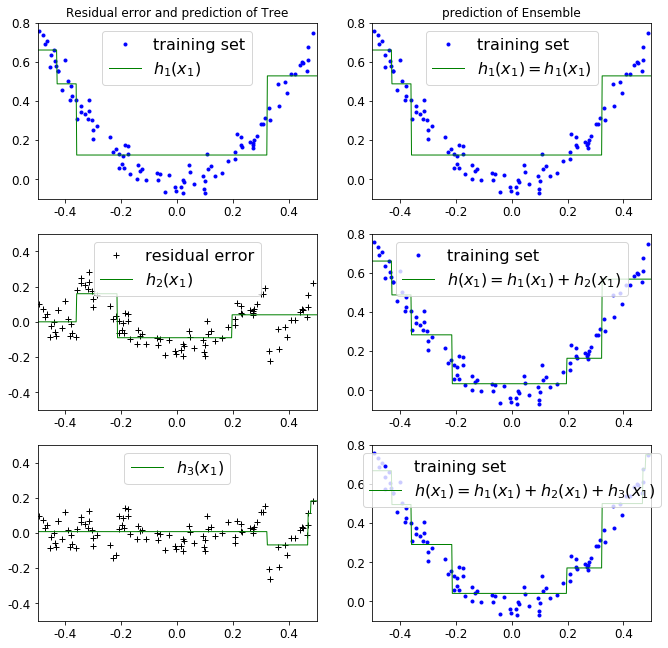

In [68]:
def plot_predictions(regressors, X, y, axes, 
                     label=None, 
                     style="r-", 
                     data_style="b.", 
                     data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=1, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], 
                 X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h_1(x_1)$", 
                 style="g-", 
                 data_label="training set")
plt.title("Residual error and prediction of Tree")

plt.subplot(322)
plot_predictions([tree_reg1], 
                 X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h_1(x_1) = h_1(x_1)$", 
                 style="g-", 
                 data_label="training set")
plt.title("prediction of Ensemble")

plt.subplot(323)
plot_predictions([tree_reg2], 
                 X, y2, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_2(x_1)$", 
                 style="g-", 
                 data_style="k+",
                 data_label="residual error")

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], 
                 X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$", 
                 style="g-", 
                 data_label="training set")

plt.subplot(325)
plot_predictions([tree_reg3], 
                 X, y3, axes=[-0.5, 0.5, -0.5, 0.5], 
                 label="$h_3(x_1)$", 
                 style="g-",
                 data_style="k+")

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], 
                 X, y, axes=[-0.5, 0.5, -0.1, 0.8], 
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$", 
                 style="g-", 
                 data_label="training set")


In [69]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=0.1, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

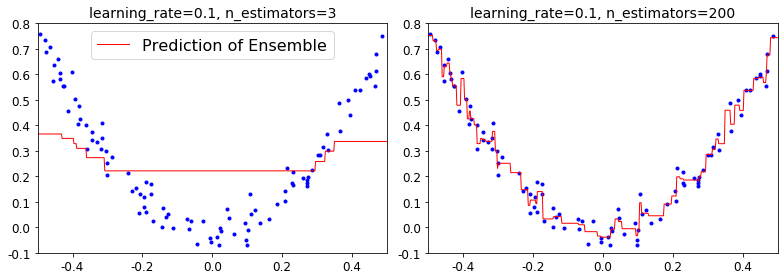

In [70]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Prediction of Ensemble")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

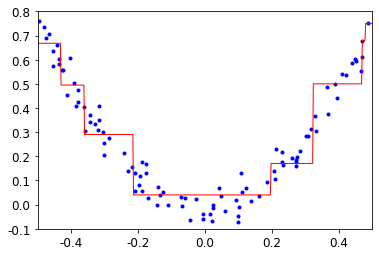

In [71]:
gbrt_fast = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt_fast.fit(X, y)

plot_predictions([gbrt_fast], X, y, axes=[-0.5, 0.5, -0.1, 0.8])


조기 종료를 사용한 그래디언트 부스팅

In [75]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2,
                                n_estimators=120,
                                random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [76]:
min_error = np.min(errors)

min_error

0.002712853325235463

Text(0.5, 1.0, 'Best model (n of tree: 55)')

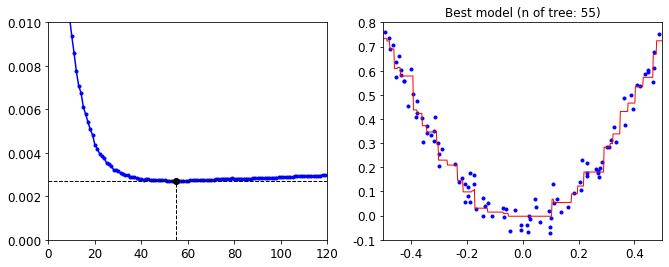

In [84]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], 
         [0, min_error], "k--", linewidth=1)
plt.plot([0, 120], [min_error, min_error], "k--", linewidth=1)
plt.plot(bst_n_estimators, min_error, "ko")
plt.axis([0, 120, 0, 0.01])

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, .8])
plt.title("Best model (n of tree: {})".format(bst_n_estimators))